In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np, pandas as pd, duckdb, matplotlib.pyplot as plt
from pathlib import Path

# Your exact folder
PROJ = Path("/Users/mahithahemadri/Downloads/Projects/Ecomm_Funnel_MTA")
DATA = PROJ / "data"
DATA.mkdir(parents=True, exist_ok=True)
print("Using data folder:", DATA)

Using data folder: /Users/mahithahemadri/Downloads/Projects/Ecomm_Funnel_MTA/data


In [5]:
need = ["spend.csv","daily_conversions.csv","orders.csv","paths.csv","funnel_events.csv"]
missing = [f for f in need if not (DATA/f).exists()]
print("Missing files:", missing)

if missing:
    np.random.seed(42)
    channels = ["Search","Social","Display","Email","Affiliate","Direct"]
    dates = pd.date_range("2024-01-01", "2024-06-30", freq="D")

    # Daily spend with noise
    base = {"Search":1400,"Social":900,"Display":700,"Email":300,"Affiliate":250,"Direct":0}
    spend = [(d, ch, round(max(0, base[ch]*np.random.normal(1.0,0.12)),2))
             for d in dates for ch in channels]
    spend = pd.DataFrame(spend, columns=["date","channel","spend"])

    # Conversions from spend (diminishing returns)
    def conv_from_spend(x,a,b): return a*(1-np.exp(-b*np.maximum(x,0)))
    daily = []
    for ch in channels:
        a = {"Search":80,"Social":50,"Display":35,"Email":20,"Affiliate":18,"Direct":10}[ch]
        b = {"Search":0.0022,"Social":0.0030,"Display":0.0028,"Email":0.0040,"Affiliate":0.0035,"Direct":0.0005}[ch]
        s = spend.loc[spend.channel==ch,"spend"].values
        lam = conv_from_spend(s, a, b)
        conv = np.random.poisson(np.maximum(lam,0.01))
        daily.append(pd.DataFrame({"date":dates,"channel":ch,"spend":s,"conversions":conv}))
    daily = pd.concat(daily, ignore_index=True)

    # Channel mix for paths based on rolling spend share
    roll = daily.pivot(index="date", columns="channel", values="spend").rolling(7, min_periods=1).mean()
    probs = roll.div(roll.sum(axis=1), axis=0).fillna(0).reindex(dates).fillna(1/len(channels))

    # Orders + paths (converted and non-converted)
    orders, paths = [], []
    order_id = 100000
    for d in dates:
        conv_d = int(daily.loc[daily.date==d,"conversions"].sum())
        nonconv = int(conv_d*np.random.uniform(0.8,1.2))
        p = probs.loc[d, channels].values; p = p/p.sum()
        def sample_path():
            L = np.random.choice([1,2,3,4], p=[0.45,0.30,0.18,0.07])
            return list(np.random.choice(channels, size=L, p=p, replace=True))
        for _ in range(conv_d):
            path = sample_path()
            rev = float(np.random.lognormal(mean=5.2, sigma=0.45))
            orders.append((order_id, d, rev))
            paths.append((order_id, " > ".join(path), path[-1], True, rev))
            order_id += 1
        for _ in range(nonconv):
            path = sample_path()
            paths.append((None, " > ".join(path), path[-1], False, 0.0))
    orders = pd.DataFrame(orders, columns=["order_id","order_date","revenue"])
    paths  = pd.DataFrame(paths,  columns=["order_id","path","last_click","converted","revenue"])

    # Funnel events
    funnel = []
    sess_id = 1
    for d in dates:
        n_sessions = int(max(200, spend.loc[spend.date==d,"spend"].sum()*0.15))
        p_row = probs.loc[d, channels].values
        for _ in range(n_sessions):
            ch = np.random.choice(channels, p=p_row)
            p_land=1.0; p_prod=0.65 if ch!="Display" else 0.55
            p_cart=0.35 if ch in ("Search","Email") else 0.28
            p_ck  =0.25 if ch in ("Search","Email") else 0.20
            p_pur =0.15 if ch in ("Search","Email") else 0.10
            flow = [("land",p_land),("product_view",p_prod),("add_to_cart",p_cart),("checkout",p_ck),("purchase",p_pur)]
            go=True
            for st,pkeep in flow:
                if not go: break
                if np.random.rand() <= pkeep:
                    funnel.append((sess_id,d,ch,st))
                else:
                    go=False
            sess_id += 1
    funnel = pd.DataFrame(funnel, columns=["session_id","date","channel","event"])

    # Save
    spend.to_csv(DATA/"spend.csv", index=False)
    daily.to_csv(DATA/"daily_conversions.csv", index=False)
    orders.to_csv(DATA/"orders.csv", index=False)
    paths.to_csv(DATA/"paths.csv", index=False)
    funnel.to_csv(DATA/"funnel_events.csv", index=False)
    print("✓ Generated files.")
else:
    print("All files exist — skipping generation.")

Missing files: ['spend.csv', 'daily_conversions.csv', 'orders.csv', 'paths.csv', 'funnel_events.csv']
✓ Generated files.


In [6]:
con = duckdb.connect()

spend  = pd.read_csv(DATA/"spend.csv", parse_dates=["date"])
dailyc = pd.read_csv(DATA/"daily_conversions.csv", parse_dates=["date"])
orders = pd.read_csv(DATA/"orders.csv", parse_dates=["order_date"])
paths  = pd.read_csv(DATA/"paths.csv")
funnel = pd.read_csv(DATA/"funnel_events.csv", parse_dates=["date"])

for n, df in [("spend",spend),("dailyc",dailyc),("orders",orders),("paths",paths),("funnel",funnel)]:
    print(f"{n:8s}", df.shape)
    con.register(n, df)

channels = sorted(spend["channel"].unique().tolist())
channels

spend    (1092, 3)
dailyc   (1092, 4)
orders   (32113, 3)
paths    (64093, 5)
funnel   (182589, 4)


['Affiliate', 'Direct', 'Display', 'Email', 'Search', 'Social']

,channel,land,p_land_to_product,p_product_to_cart,p_cart_to_checkout,p_checkout_to_purchase,overall_conv
0,Search,38657.0,0.653,0.347,0.250,0.150,0.009
1,Email,8104.0,0.648,0.343,0.270,0.132,0.008
2,Affiliate,6816.0,0.651,0.281,0.194,0.112,0.004
3,Display,19223.0,0.540,0.281,0.192,0.116,0.003
4,Social,24458.0,0.654,0.275,0.192,0.093,0.003


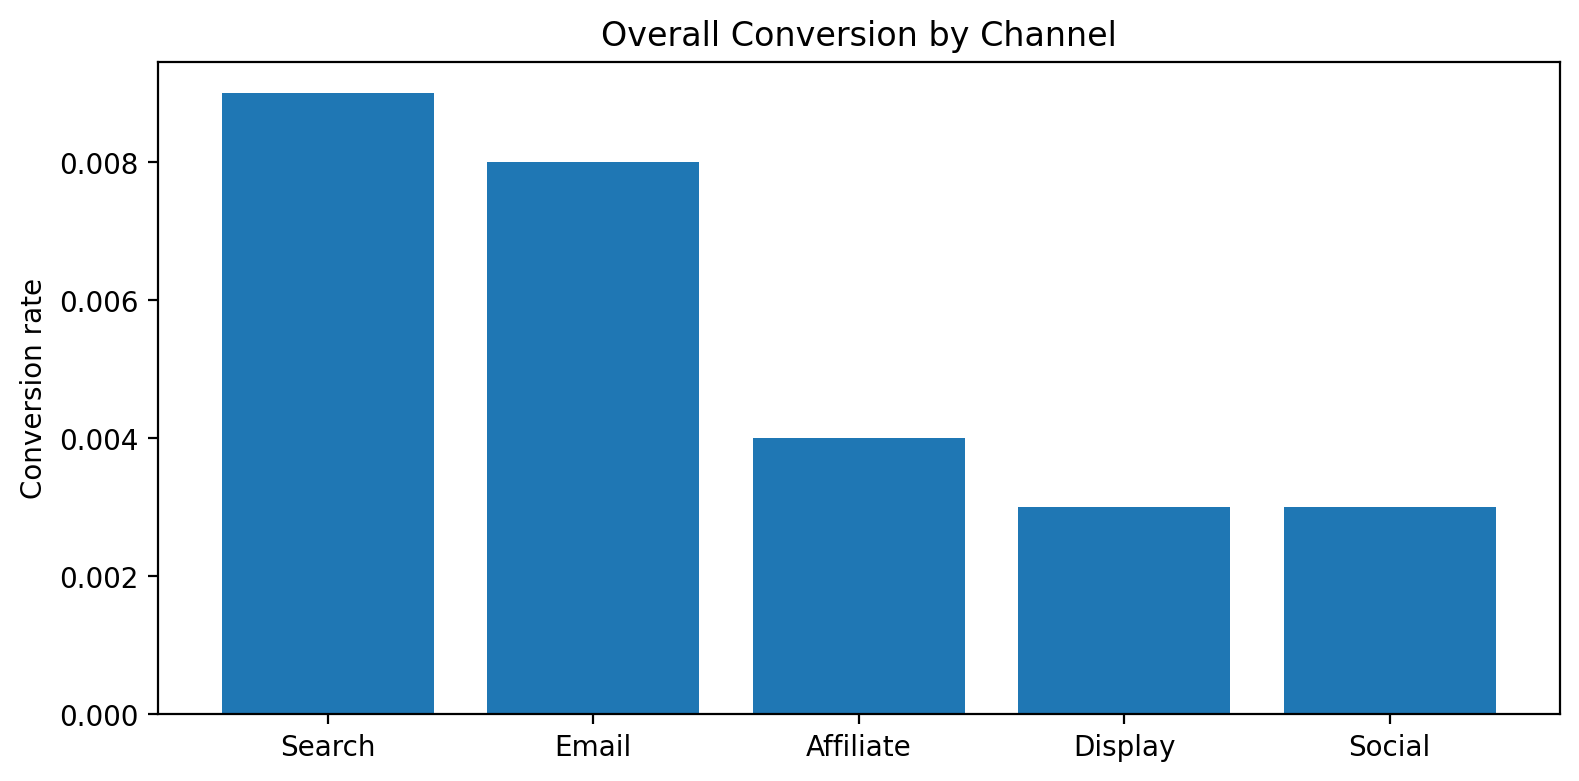

In [7]:
funnel_rates = con.execute("""
WITH base AS (
  SELECT channel, event, COUNT(*) AS n
  FROM funnel GROUP BY 1,2
),
wide AS (
  SELECT channel,
         SUM(CASE WHEN event='land'         THEN n ELSE 0 END) AS land,
         SUM(CASE WHEN event='product_view' THEN n ELSE 0 END) AS product_view,
         SUM(CASE WHEN event='add_to_cart'  THEN n ELSE 0 END) AS add_to_cart,
         SUM(CASE WHEN event='checkout'     THEN n ELSE 0 END) AS checkout,
         SUM(CASE WHEN event='purchase'     THEN n ELSE 0 END) AS purchase
  FROM base GROUP BY 1
)
SELECT channel,
       land,
       ROUND(product_view*1.0/NULLIF(land,0),3)        AS p_land_to_product,
       ROUND(add_to_cart*1.0/NULLIF(product_view,0),3) AS p_product_to_cart,
       ROUND(checkout*1.0/NULLIF(add_to_cart,0),3)     AS p_cart_to_checkout,
       ROUND(purchase*1.0/NULLIF(checkout,0),3)        AS p_checkout_to_purchase,
       ROUND(purchase*1.0/NULLIF(land,0),3)            AS overall_conv
FROM wide
ORDER BY overall_conv DESC;
""").df()
display(funnel_rates)

plt.figure(figsize=(8,4))
plt.bar(funnel_rates["channel"], funnel_rates["overall_conv"])
plt.title("Overall Conversion by Channel"); plt.ylabel("Conversion rate")
plt.tight_layout(); plt.show()

In [8]:
last_click = con.execute("""
SELECT last_click AS channel,
       SUM(revenue) AS revenue,
       COUNT(*)     AS orders
FROM paths
WHERE converted = TRUE
GROUP BY 1 ORDER BY revenue DESC;
""").df()
last_click

,channel,revenue,orders
0,Search,2.581409e+06,12799
1,Social,1.646982e+06,8212
2,Display,1.247733e+06,6207
3,Email,5.456052e+05,2693
4,Affiliate,4.450965e+05,2202


In [9]:


# Build path sequences
seqs = []
for _, r in paths.iterrows():
    chs = r["path"].split(" > ")
    seqs.append((chs, bool(r["converted"]), float(r["revenue"])))

def build_states(channels):
    return ["START"] + channels + ["CONVERSION","NULL"]

def trans_counts(seqs, states):
    idx = {s:i for i,s in enumerate(states)}
    M = np.zeros((len(states), len(states)), dtype=float)
    for chs, converted, _ in seqs:
        chain = ["START"] + chs + (["CONVERSION"] if converted else ["NULL"])
        for i in range(len(chain)-1):
            M[idx[chain[i]], idx[chain[i+1]]] += 1
    return M

def conv_prob(M, states, start="START", conv="CONVERSION", null="NULL"):
    idx = {s:i for i,s in enumerate(states)}
    # transition probabilities
    P = M / np.maximum(M.sum(axis=1, keepdims=True), 1e-12)
    A_idx = [idx[conv], idx[null]]
    T_idx = [i for i in range(len(states)) if i not in A_idx]
    P_TT = P[np.ix_(T_idx, T_idx)]
    P_TA = P[np.ix_(T_idx, A_idx)]
    I = np.eye(P_TT.shape[0])
    N = np.linalg.inv(I - P_TT)
    B = N @ P_TA
    start_row = T_idx.index(idx[start])
    return B[start_row, 0]  # prob of absorbing in CONVERSION

# Base conversion probability
states0 = build_states(channels)
M0 = trans_counts(seqs, states0)
base_conv = conv_prob(M0, states0)

# Removal effect per channel
contrib = {}
for ch in channels:
    keep_states = [s for s in states0 if s != ch]
    # Build reduced matrix by copying over non-removed transitions
    idx0 = {s:i for i,s in enumerate(states0)}
    idxk = {s:i for i,s in enumerate(keep_states)}
    Mk = np.zeros((len(keep_states), len(keep_states)))
    for si in states0:
        if si == ch: continue
        for sj in states0:
            if sj == ch: continue
            Mk[idxk[si], idxk[sj]] = M0[idx0[si], idx0[sj]]
    conv_rm = conv_prob(Mk, keep_states)
    contrib[ch] = max(0.0, base_conv - conv_rm)

# Scale contributions to total observed revenue
total_rev = float(orders["revenue"].sum())
total_contrib = sum(contrib.values()) or 1e-9
mta = pd.DataFrame({
    "channel": list(contrib.keys()),
    "contribution": [contrib[c] for c in contrib],
    "attributed_revenue": [contrib[c]/total_contrib*total_rev for c in contrib]
}).sort_values("attributed_revenue", ascending=False)

# Approximate orders from avg order value
mta["orders"] = (mta["attributed_revenue"] / orders["revenue"].mean()).round().astype(int)
mta

,channel,contribution,attributed_revenue,orders
5,Social,0.001633,6.466825e+06,32113
0,Affiliate,0.000000,0.000000e+00,0
1,Direct,0.000000,0.000000e+00,0
2,Display,0.000000,0.000000e+00,0
3,Email,0.000000,0.000000e+00,0
4,Search,0.000000,0.000000e+00,0


In [10]:
spend_ch = spend.groupby("channel", as_index=False)["spend"].sum()

lc = last_click.merge(spend_ch, on="channel", how="left")
lc["ROAS_last"] = lc["revenue"] / lc["spend"]
lc["CAC_last"]  = lc["spend"] / lc["orders"]

mk = mta.merge(spend_ch, on="channel", how="left")
mk["ROAS_mta"] = mk["attributed_revenue"] / mk["spend"]
mk["CAC_mta"]  = mk["spend"] / mk["orders"]

roas = lc[["channel","ROAS_last","CAC_last"]].merge(
       mk[["channel","ROAS_mta","CAC_mta"]], on="channel")
roas.sort_values("ROAS_mta", ascending=False)

,channel,ROAS_last,CAC_last,ROAS_mta,CAC_mta
1,Social,10.109473,19.838613,39.69455,5.073169
0,Search,9.962003,20.245761,0.00000,inf
2,Display,9.823268,20.463689,0.00000,inf
3,Email,9.991530,20.277300,0.00000,inf
4,Affiliate,9.807383,20.610272,0.00000,inf


,channel,current_daily_spend,recommended_daily_spend,delta
5,Social,895.135659,1062.747186,167.611527
3,Email,300.037198,392.758468,92.721270
0,Affiliate,249.361648,313.553297,64.191648
4,Search,1423.766429,1455.862253,32.095824
1,Direct,0.000000,0.000000,0.000000
2,Display,697.901758,697.901758,0.000000


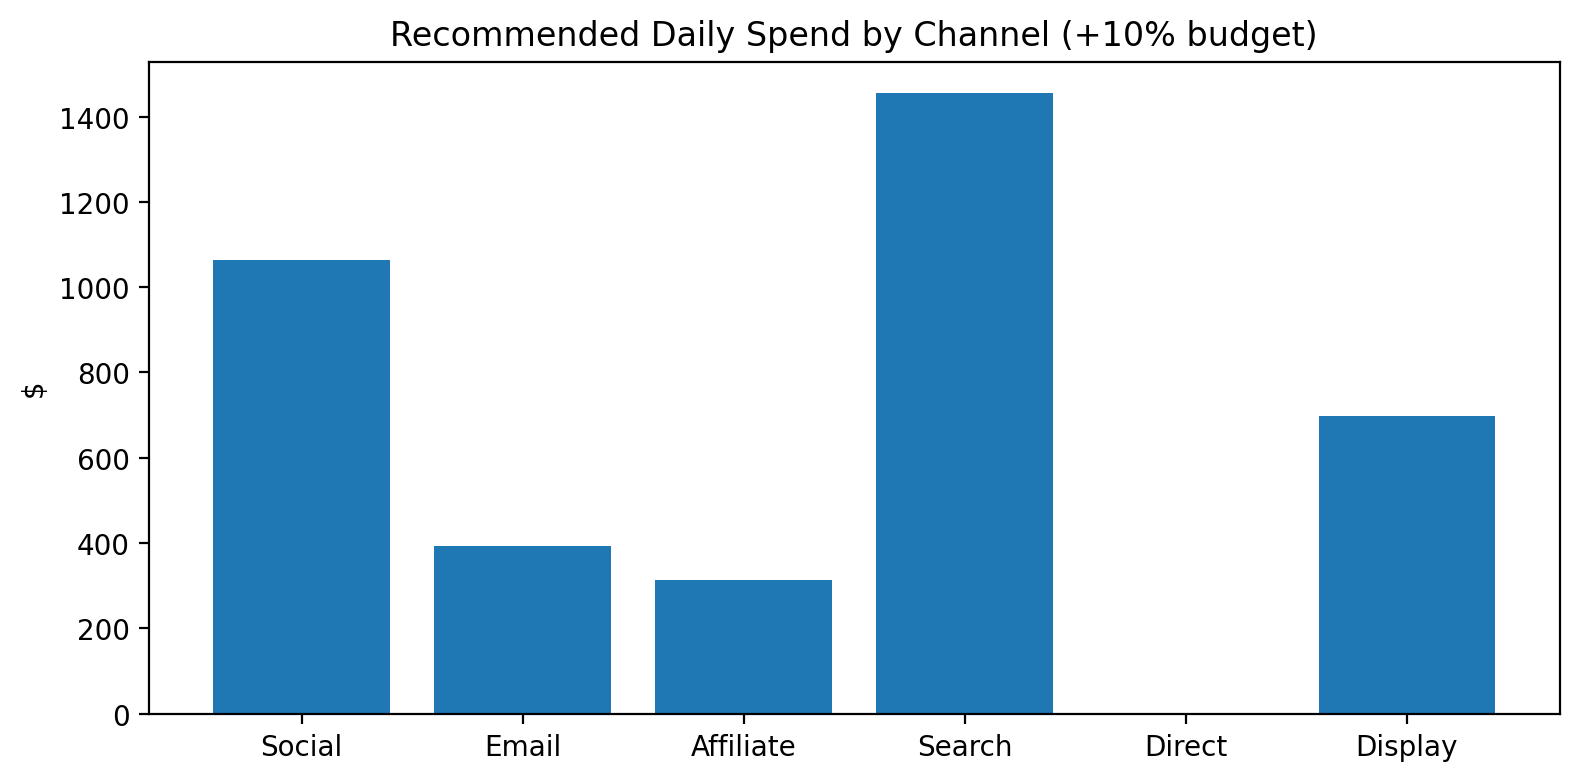

In [11]:
# Fit simple a*(1-exp(-b*x)) per channel to daily conversions
agg = dailyc.groupby("channel")
resp = {}

for ch, g in agg:
    x = g["spend"].values
    y = g["conversions"].values
    alpha = max(5, y.max())  # asymptote guess
    betas = np.linspace(1e-5, 0.01, 200)
    def conv_hat(b): return alpha*(1-np.exp(-b*np.maximum(x,0)))
    sse = np.array([np.mean((conv_hat(b)-y)**2) for b in betas])
    bstar = float(betas[sse.argmin()])
    resp[ch] = {"alpha":float(alpha), "beta":bstar, "x":x, "y":y}

# Greedy reallocation: move +10% daily budget toward highest marginal ROI
avg_spend = spend.groupby("channel")["spend"].mean().to_dict()
arpu = float(orders["revenue"].mean())  # avg revenue per order

def mroi(ch, s):
    a, b = resp[ch]["alpha"], resp[ch]["beta"]
    # derivative of conversions wrt spend
    marg_conv = a*b*np.exp(-b*max(s,0))
    return marg_conv * arpu  # $ revenue per $ spend

total_spend = spend["spend"].sum()
pool = 0.10 * total_spend / len(spend["date"].unique())  # 10% daily pool
current = avg_spend.copy()

step = pool/100.0
for _ in range(100):
    best = max(channels, key=lambda c: mroi(c, current[c]))
    current[best] += step

reco = pd.DataFrame({
    "channel": channels,
    "current_daily_spend": [avg_spend[c] for c in channels],
    "recommended_daily_spend": [current[c] for c in channels]
})
reco["delta"] = reco["recommended_daily_spend"] - reco["current_daily_spend"]
reco.sort_values("delta", ascending=False, inplace=True)
display(reco)

plt.figure(figsize=(8,4))
plt.bar(reco["channel"], reco["recommended_daily_spend"])
plt.title("Recommended Daily Spend by Channel (+10% budget)")
plt.ylabel("$"); plt.tight_layout(); plt.show()

In [12]:
outdir = PROJ  # save next to the project
(funnel_rates).to_csv(outdir/"b_funnel_rates.csv", index=False)
last_click.to_csv(outdir/"b_last_click.csv", index=False)
mta.to_csv(outdir/"b_markov_mta.csv", index=False)
roas.to_csv(outdir/"b_roas_summary.csv", index=False)
reco.to_csv(outdir/"b_budget_reco.csv", index=False)
print("Saved to:", outdir)

Saved to: /Users/mahithahemadri/Downloads/Projects/Ecomm_Funnel_MTA


In [13]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.image as mpimg

# 3 quick charts to embed
plt.figure(figsize=(7,4))
plt.bar(funnel_rates["channel"], funnel_rates["overall_conv"])
plt.title("Overall Conversion by Channel"); plt.tight_layout()
plt.savefig(PROJ/"b_conv_by_channel.png", dpi=160); plt.close()

plt.figure(figsize=(7,4))
plt.bar(roas["channel"], roas["ROAS_mta"])
plt.title("ROAS (Markov MTA) by Channel"); plt.tight_layout()
plt.savefig(PROJ/"b_roas_mta.png", dpi=160); plt.close()

plt.figure(figsize=(7,4))
plt.bar(reco["channel"], reco["recommended_daily_spend"])
plt.title("Recommended Daily Spend (+10%)"); plt.tight_layout()
plt.savefig(PROJ/"b_reco.png", dpi=160); plt.close()

img1 = mpimg.imread(PROJ/"b_conv_by_channel.png")
img2 = mpimg.imread(PROJ/"b_roas_mta.png")
img3 = mpimg.imread(PROJ/"b_reco.png")

with PdfPages(PROJ/"Ecomm_Funnel_MTA_OnePager.pdf") as pdf:
    fig = plt.figure(figsize=(11,8.5), constrained_layout=True)
    gs = fig.add_gridspec(2,3, height_ratios=[0.28,0.72])
    axh = fig.add_subplot(gs[0,:]); axh.axis("off")
    axh.text(0.01,0.75,"E-commerce Funnel & Marketing Efficiency — One Pager",
             fontsize=16, fontweight="bold")
    axh.text(0.01,0.45,"Funnel, Markov MTA, ROAS & budget reallocation (+10%).",
             fontsize=11)
    a1 = fig.add_subplot(gs[1,0]); a1.imshow(img1); a1.set_title("Conversion by Channel"); a1.axis("off")
    a2 = fig.add_subplot(gs[1,1]); a2.imshow(img2); a2.set_title("ROAS (MTA)"); a2.axis("off")
    a3 = fig.add_subplot(gs[1,2]); a3.imshow(img3); a3.set_title("Spend Recommendation"); a3.axis("off")
    pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

print("Saved:", PROJ/"Ecomm_Funnel_MTA_OnePager.pdf")

Saved: /Users/mahithahemadri/Downloads/Projects/Ecomm_Funnel_MTA/Ecomm_Funnel_MTA_OnePager.pdf
